## Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
%matplotlib inline
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Anomaly detection models from pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'
%run -i '../scripts/anomaly_helper_functions.py'

## Load Cleaned  Data

In [4]:
df = pd.read_csv('../data/cleaned_data_2014_to_2017.csv')
df.head()

,Record,Location,X,Y,Date,Time,Environment,Road_Surface,Traffic_Control,Collision_Location,Light,Collision_Classification,Impact_type,Year,Month,Week_day
0,1,RIDEAU ST @ WALLER ST,368282.69327,5.032275e+06,2014-02-21,06:07:00,02 - Rain,02 - Wet,01 - Traffic signal,03 - At intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,February,Friday
1,2,HINES RD btwn INNOVATION DR & SOLANDT RD,350172.08885,5.022740e+06,2014-08-02,13:55:00,01 - Clear,01 - Dry,10 - No control,04 - At/near private drive,01 - Daylight,01 - Fatal injury,02 - Angle,2014,August,Saturday
2,4,MONTREAL RD @ BATHGATE DR/BURMA RD,373224.24847,5.034518e+06,2014-07-29,16:31:00,01 - Clear,01 - Dry,01 - Traffic signal,03 - At intersection,01 - Daylight,01 - Fatal injury,05 - Turning movement,2014,July,Tuesday
3,5,RICHMOND RD btwn FALLOWFIELD RD & RUSHMORE RD,358156.20481,5.012570e+06,2014-08-05,20:05:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,05 - Dusk,01 - Fatal injury,07 - SMV other,2014,August,Tuesday
4,6,PARKDALE AVE btwn RUSKIN ST & INGLEWOOD PL,365558.54334,5.028338e+06,2014-04-19,10:22:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,01 - Daylight,01 - Fatal injury,06 - SMV unattended vehicle,2014,April,Saturday


In [5]:
# Data Shape
df.shape

(57768, 16)

In [6]:
# Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57768 entries, 0 to 57767
Data columns (total 16 columns):
Record                      57768 non-null int64
Location                    57768 non-null object
X                           57768 non-null float64
Y                           57768 non-null float64
Date                        57768 non-null object
Time                        57768 non-null object
Environment                 57767 non-null object
Road_Surface                57768 non-null object
Traffic_Control             57733 non-null object
Collision_Location          57762 non-null object
Light                       57766 non-null object
Collision_Classification    57768 non-null object
Impact_type                 57768 non-null object
Year                        57768 non-null int64
Month                       57768 non-null object
Week_day                    57768 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 7.1+ MB


We have 3 numerical and 12 categorical attributes in the dataset. Traffic_Control, Collision_Location, and Light have missing values. We will come back to the missing values later in data preprocessing.


The Year attribute has only four levels, therefore it would be better to consider it as a categorical attributes

In [7]:
# Check unique values
df.Year.unique()

array([2014, 2015, 2016, 2017])

In [8]:
# Convert to object
df.Year = df.Year.astype('O')

We will also drop some attributes that won't be very useful in building predictive model

In [9]:
# Drop specified attributes 
df = df.drop(['Time', 'Date', 'Record','Location'], axis = 1)

## Class Distribution

In [11]:
df.Collision_Classification.value_counts()

03 - P.D. only           46790
02 - Non-fatal injury    10885
01 - Fatal injury           93
Name: Collision_Classification, dtype: int64

## Create a Binary Class

The P.D (Property Damage) only and the Non-fatal injury classes can be combined to form a general Non-fatal injury class reducing the dataset to a binary class problem. 

In [12]:
df.Collision_Classification = df.Collision_Classification.replace('03 - P.D. only', '02 - Non-fatal injury').\
replace('02 - Non-fatal injury', 'Non-fatal injury')

In [13]:
df.Collision_Classification = df.Collision_Classification.replace('01 - Fatal injury', 'Fatal injury')

In [14]:
df.Collision_Classification.value_counts()

Non-fatal injury    57675
Fatal injury           93
Name: Collision_Classification, dtype: int64

##  Feature Matrix  and Class Variable

In [15]:
X, y = df.drop(['Collision_Classification'], axis = 1), df['Collision_Classification']

## Create a Test Set

In [16]:
# Create 70% training set and 30% test set using stratify sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify = y)

In [17]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print("**************************************************")
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 Non-fatal injury    99.839256
Fatal injury         0.160744
Name: Collision_Classification, dtype: float64
**************************************************
Test set class distribution:
 Non-fatal injury    99.83844
Fatal injury         0.16156
Name: Collision_Classification, dtype: float64


In [18]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (40437, 11) (40437,)
Test set size: (17331, 11) (17331,)


## Impute Missing Value

As we saw above, there are some attributes with missing values. We will now impute the missing values in those attributes for a better performance

In [19]:
# Instantiate the imputer class
imputer = DataFrameImputer()

# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.fit_transform(X_test)

It is good to cross-check whether the missing values have been imputed

In [20]:
# Cross-check for missing values
print(X_train_imputed.isnull().sum())
print('***************************')
print(X_test_imputed.isnull().sum())

X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64
***************************
X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64


## Standardize the Numerical Features and Convert the Categorical Attributes to Binaries
As we saw above, most of the attributes are categorical, and they need to be converted to numeric before applying the machine learning algorithms. We also need to scale the numerical attributes for a better performance

In [21]:
# Numerical attributes list
num_list = list(X.select_dtypes('number'))

# Categorical attributes list
cat_list = list(X.select_dtypes('O'))

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_list]

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_list]

# Build a pipeline for the data pre-processing
mapper =  DataFrameMapper(num_attribs + cat_attribs, df_out = True) 

# Fit transform the training set
X_train_prepared = mapper.fit_transform(X_train_imputed)

# Only transform the test set
X_test_prepared = mapper.transform(X_test_imputed)

In [22]:
print('Training set size after pre-processing:', X_train_prepared.shape)
print('Test set size after pre-processing:', X_test_prepared.shape)

Training set size after pre-processing: (40437, 81)
Test set size after pre-processing: (17331, 81)


## Dimensionality Reduction

In [185]:
# PCA with unscaled training data
pca = PCA(n_components = 2)
X_train_reduced_pca = pca.fit_transform(X_train_prepared)

In [186]:
# Put in dataframe
X_train_reduced_pca = pd.DataFrame(data = X_train_reduced_pca)
X_train_reduced_pca.columns = ['PC1', 'PC2']
X_train_reduced_pca['Class'] = y_train.reset_index(drop = True)
X_train_reduced_pca.head()

,PC1,PC2,Class
0,-0.811892,-0.493110,Non-fatal injury
1,-1.733245,1.522263,Non-fatal injury
2,1.463723,-1.400462,Non-fatal injury
3,-1.004595,0.974407,Non-fatal injury
4,-0.651416,-1.123288,Non-fatal injury


In [187]:
# Pickle pca dataframe
X_train_reduced_pca.to_pickle('../data/pca.pkl') 

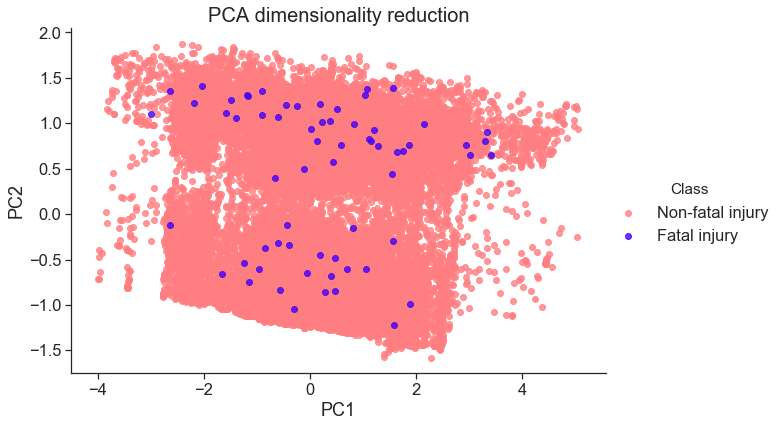

In [188]:
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Load file
X_train_reduced_pca = pd.read_pickle('../data/pca.pkl') 
# Plot
sns.lmplot(data = X_train_reduced_pca, x = 'PC1', y = 'PC2', hue = 'Class', 
           fit_reg = False, height= 6, aspect=1.5, palette = 'gnuplot2_r')
plt.title('PCA dimensionality reduction', fontsize = 20)
plt.savefig('../image/pca.png')

##  Encode the Class Variable

In [26]:
# Dictionary mapping
map_target = {'Fatal injury': 1, 'Non-fatal injury': 0}

# Map to discrete numbers
y_train_label = y_train.map(map_target)
y_test_label = y_test.map(map_target)

# Anomaly Detection Models

In [35]:
# PCA 
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_prepared)
X_test_pca = pca.transform(X_test_prepared)

In [36]:
X_train_pca.shape

(40437, 34)

## 1. Isolation Forest

In [37]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train_pca)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test_pca)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test_pca)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evalaute_performance(y_train_label, y_train_pred)

print("\nOn Test Data:")
evalaute_performance(y_test_label, y_test_pred)


On Training Data:
Accuracy:  0.898781
AUROC: 0.511553
AUPRC: 0.001653
Confusion matrix:
 [[36336  4036]
 [   57     8]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     40372
           1       0.00      0.12      0.00        65

    accuracy                           0.90     40437
   macro avg       0.50      0.51      0.48     40437
weighted avg       1.00      0.90      0.95     40437

*****************************************************************************

On Test Data:
Accuracy:  0.902083
AUROC: 0.558741
AUPRC: 0.002034
Confusion matrix:
 [[15628  1675]
 [   22     6]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     17303
           1       0.00      0.21      0.01        28

    accuracy                           0.90     17331
   macro avg       0.50      0.56      0.48     17331
weighted avg       1.00      0.90    